# <u>__Prédiction de genres musicaux__</u>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Nous allons étudier un cas classique de classification multiclasse: Nous avons un dataset constitué de nombreux morceaux qui possèdent de nombreux caractéristiques tel qu'un nom, un artiste ou la popularité. L'objectif sera de determiné à partir de ces nombreuses variables le genre musicale de chacun de nos morceaux ('Electronic', 'Anime', nan, 'Jazz', 'Alternative', 'Country',
       'Rap', 'Blues', 'Rock', 'Classical', 'Hip-Hop').

In [2]:
df = pd.read_csv('music_genre.csv')

df.head(5)

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


In [3]:
df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'obtained_date', 'valence', 'music_genre'],
      dtype='object')

Nous avons reçu notre dataset 'propre' avec très peu de valeurs manquantes:

In [4]:
print(f"Nous avons {df.isna().sum().sum()} valeurs manquantes sur {len(df)} valeurs")

Nous avons 90 valeurs manquantes sur 50005 valeurs


Bien que nous ayons une notion de date avec la variable "obtained_date" qui est la variable associée à la date d'obtention, nous n'étudions pas de série temporelle, supprimé les lignes avec des valeurs manquantes ne nous pose donc pas de problème, nous remarquons que le tempo possède des éléments string "?" sûrement utilisé à place du Nan par celui qui a fournit le dataset sur kaggle, que nous ne pouvons pas voir avec isna(). Nous les remplaçons par la moyenne des autres valeurs qui appartiennent à un mêmes groupe de musique, car le tempo devrait être similaire pour des musiques du mêmes genre ou du moins suivre une tendance.

In [5]:
df.dtypes

instance_id         float64
artist_name          object
track_name           object
popularity          float64
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
key                  object
liveness            float64
loudness            float64
mode                 object
speechiness         float64
tempo                object
obtained_date        object
valence             float64
music_genre          object
dtype: object

In [6]:
df=df.dropna()
#On transforme tous les '?' en nan:
df['tempo'] = pd.to_numeric(df['tempo'],errors='coerce')

print(f"On a donc {df['tempo'].isna().sum()} Nan values après avoir transformé les '?'")

for genre in df["music_genre"].unique():
    df.loc[(df["music_genre"]==genre)*df["tempo"].isna(),'tempo'] = df.loc[(df["music_genre"]==genre)*(~ df["tempo"].isna()),'tempo'].mean()

print(df['tempo'].isna().sum())

On a donc 4980 Nan values après avoir transformé les '?'
0


In [7]:
float('115.00200000000001')

115.00200000000001

De plus nous avons deux variables qualitatives "mode", "key", pour pouvoir les utiliser lors de l'apprentissage, nous créeons des indicatrices lors de la présence ou non d'un élément spécifique pour chacune des valeurs que peuvent prendre les variables:

In [8]:
key_elements = df["key"].unique()
print(f"Les différents éléments de 'key' sont: { key_elements }")

Les différents éléments de 'key' sont: ['A#' 'D' 'G#' 'C#' 'F#' 'B' 'G' 'F' 'A' 'C' 'E' 'D#']


In [9]:
for j in key_elements:
    df[j]=(df["key"]==j)*1

In [10]:
mode_elements = df["mode"].unique()
print(f"Les différents éléments de 'mode' sont: {mode_elements}") 

Les différents éléments de 'mode' sont: ['Minor' 'Major']


In [11]:
for j in mode_elements:
    df[j]=(df["mode"]==j).astype(int)

In [12]:
df=df.drop(columns=["key","mode"])
df.columns

Index(['instance_id', 'artist_name', 'track_name', 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'obtained_date', 'valence', 'music_genre', 'A#', 'D', 'G#', 'C#', 'F#',
       'B', 'G', 'F', 'A', 'C', 'E', 'D#', 'Minor', 'Major'],
      dtype='object')

Mis à part les variables 'instance_id', 'artist_name', 'track_name' qui nous permettent de nommer nos données, la variable "obtained_date" est inutile pour la classification car nous avons 5 dates qui n'apportent pas d'informations particulière:

In [13]:
df["obtained_date"].unique()

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr', '0/4'], dtype=object)

Pour la classification nous nous concentrons sur les variables suivantes: 'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'music_genre', 'A#', 'D', 'G#', 'C#', 'F#',
       'B', 'G', 'F', 'A', 'C', 'E', 'D#', 'Minor', 'Major'.

Bien sûr le choix des variables les plus importantes dépend du type de modèle de classification utilisée.

On divise notre dataset en base de donnée test et d'entrainement (20% et 80%) de manière qu'il y est un nombre equivalent de genre pour chacune des bases d'entraînement:

In [14]:
from sklearn.model_selection import train_test_split

X = df[['popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'A#', 'D', 'G#', 'C#', 'F#',
       'B', 'G', 'F', 'A', 'C', 'E', 'D#', 'Minor', 'Major']]

y = df['music_genre']
for j, value in enumerate(y.unique()):
    print(f"{value} est la valeur {j}")
    df.loc[y==value,"token_class"] = j

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Electronic est la valeur 0
Anime est la valeur 1
Jazz est la valeur 2
Alternative est la valeur 3
Country est la valeur 4
Rap est la valeur 5
Blues est la valeur 6
Rock est la valeur 7
Classical est la valeur 8
Hip-Hop est la valeur 9


In [15]:
y_train.value_counts()

Country        4000
Anime          4000
Hip-Hop        4000
Rock           4000
Classical      4000
Rap            4000
Blues          4000
Alternative    4000
Jazz           4000
Electronic     4000
Name: music_genre, dtype: int64

In [16]:
y_test.value_counts()

Rock           1000
Country        1000
Electronic     1000
Classical      1000
Alternative    1000
Jazz           1000
Blues          1000
Anime          1000
Rap            1000
Hip-Hop        1000
Name: music_genre, dtype: int64

#### __I - Modèle de Regression logistique.__

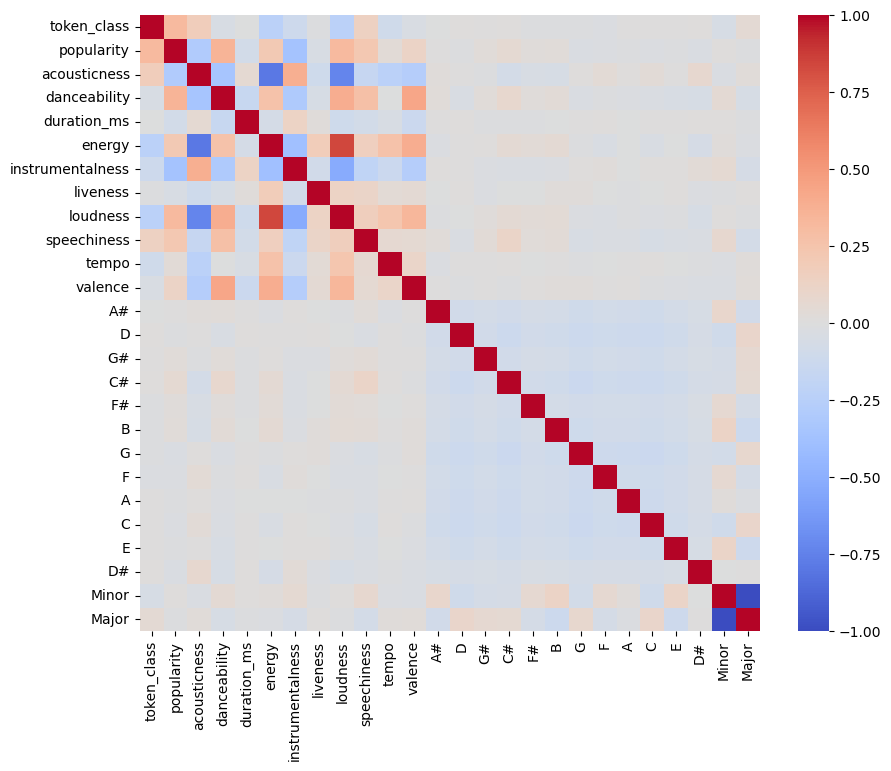

In [17]:
import seaborn as sns

correlation_matrix = df[["token_class",'popularity',
       'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'A#', 'D', 'G#', 'C#', 'F#',
       'B', 'G', 'F', 'A', 'C', 'E', 'D#', 'Minor', 'Major',]].corr()

# Create the heatmap
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap = 'coolwarm')
plt.show()

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import accuracy_score

clf = LR(multi_class="multinomial",n_jobs=-1).fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.2965

#### __II - Linear Discriminent Analysis (LDA).__

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
accuracy

0.5158